# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [11]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

from tqdm.notebook import tqdm

In [12]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

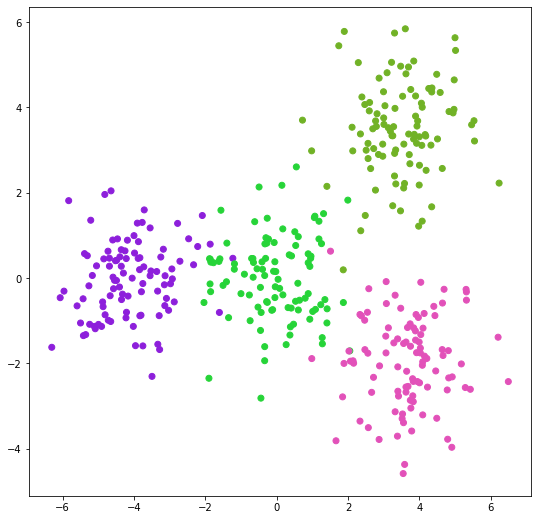

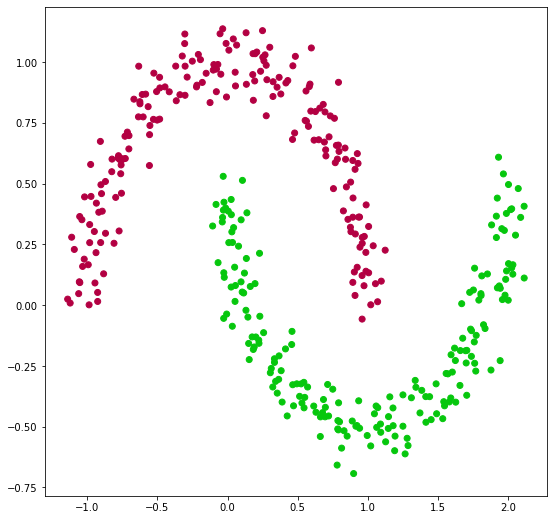

In [13]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [16]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.__n_clusters = n_clusters
        self.__max_iter = max_iter
        self.__init = init
        self.centroids = np.array([])

        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        self.centroids = self.__init_centroids(X, np.empty((0, X.shape[1])))

        for i in tqdm(range(self.__max_iter)):
            centroids = np.empty((0, X.shape[1]))

            closest_centers = self.predict(X)
            
            for n_centr in range(self.__n_clusters):
                cluster_points = X[closest_centers == n_centr]

                if len(cluster_points > 0):
                    centroids = np.append(centroids, [cluster_points.mean(axis=0)], axis=0)
               
            self.centroids = self.__init_centroids(X, centroids)


    def __init_centroids(self, X, centroids):
        if self.__init == 'random':
            return self.__init_random_centroids(X, centroids)
        if self.__init == 'sample':
            return self.__init_sample_centroids(X, centroids)
        if self.__init == 'k-means++':
            return self.__init_k_plus_centroids(X, centroids)

    
    def __init_random_centroids(self, X, centroids):
        n_features = X.shape[1]
        feature_range = list(zip(np.apply_along_axis(min, 1, X.T), 
                            np.apply_along_axis(max, 1, X.T)))
        
        new_centroids = np.zeros((self.__n_clusters - len(centroids), n_features))

        for feature in range(n_features):
            feature_min, feature_max = feature_range[feature]
            new_centroids.T[feature] = np.random.uniform(feature_min, feature_max, new_centroids.shape[0])

        return np.concatenate((centroids, new_centroids), axis=0)

    def __init_sample_centroids(self, X, centroids):
        new_centroids = X[np.random.choice(X.shape[0], self.__n_clusters - len(centroids))]
        return np.concatenate((centroids, new_centroids), axis=0)


    def __init_k_plus_centroids(self, X, centroids):
        if len(centroids) == 0:
            centroids = np.array([X[np.random.randint(X.shape[0])]])

        for i in range(self.__n_clusters - len(centroids)):
            new_centroid = self.__prob_choice_center(X, centroids)
            centroids = np.append(centroids, new_centroid, axis=0)

        return centroids

    
    def __prob_choice_center(self, X, centroids):
        get_dist = lambda y: np.sum(np.apply_along_axis(lambda x: np.linalg.norm(x - y), 1, centroids))
        distances_squared = np.apply_along_axis(lambda x: get_dist(x) ** 2, 1, X)

        return X[np.random.choice(X.shape[0], 1, list(distances_squared / distances_squared.sum()))]


    
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        
        count_distance_func = lambda y: np.apply_along_axis(lambda x: np.linalg.norm(x - y), 1, self.centroids)
        return np.apply_along_axis(lambda x: np.argmin(count_distance_func(x)), 1, X)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

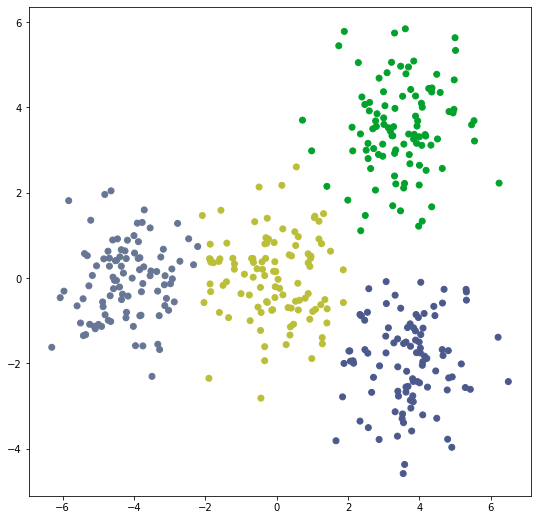

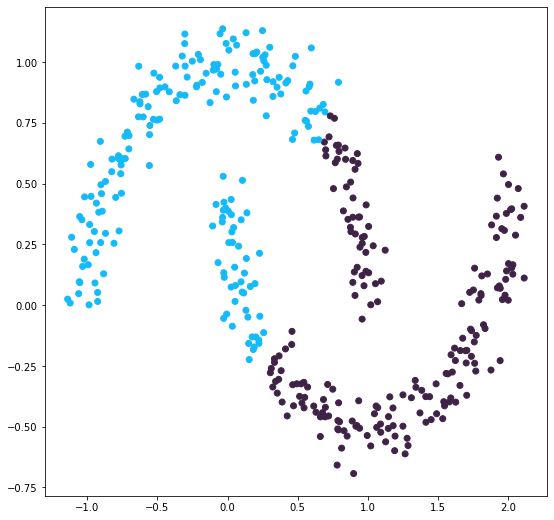

In [17]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=50)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=50)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [18]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.__eps = eps
        self.__min_samples = min_samples
        self.__leaf_size = leaf_size
        self.__metric = metric

        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        tree = KDTree(X, leaf_size=self.__leaf_size, metric=self.__metric)
        self.__neighbours = tree.query_radius(X, r=self.__eps)
        self.__core_samples = np.array([len(x) >= self.__min_samples for x in self.__neighbours])
      
        self.__labels = -np.ones(X.shape[0], dtype=np.int)
        indexes = np.array(range(X.shape[0]))
        current_label = 0

        for core in indexes[self.__core_samples]:
            if self.__labels[core] == -1:
                queue = deque([core])
                
                while len(queue) > 0:
                    sub_core = queue.pop()
                    self.__labels[sub_core] = current_label

                    if self.__core_samples[sub_core]:
                        for u in self.__neighbours[sub_core]:
                            if self.__labels[u] == -1:
                                queue.append(u)

                current_label += 1
        
        return self.__labels

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

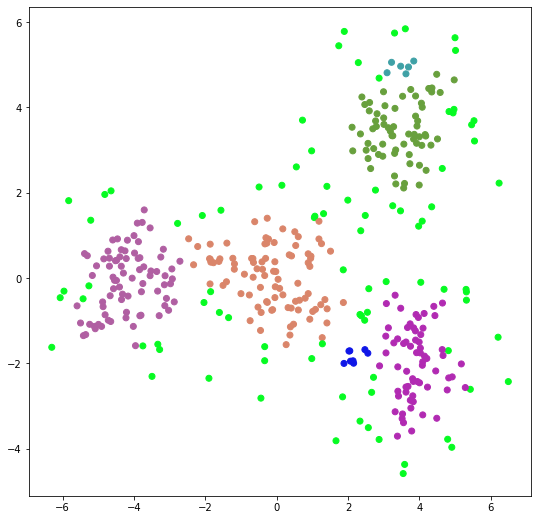

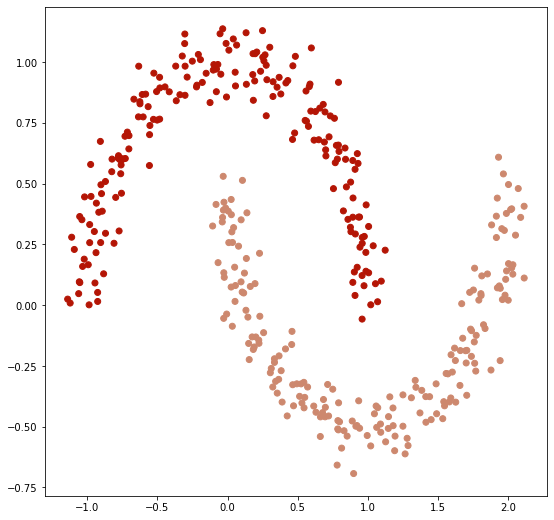

In [20]:
dbscan = DBScan(eps=0.5, min_samples=6)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.2, min_samples=5)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [337]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.__n_clusters = n_clusters
        self.__linkage = linkage
    

    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать 
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        self.__clusters = [[x] for x in range(X.shape[0])]
        self.__distances = self.__count_clusters_distance(X)

        for i in tqdm(range(len(self.__clusters), self.__n_clusters, -1)):
            first_to_merge, second_to_merge = self.__find_merge_clusters()

            new_cluster = self.__clusters[first_to_merge] + self.__clusters[second_to_merge]

            self.__clusters[first_to_merge] = new_cluster
            self.__clusters[second_to_merge] = []

            self.__update_distances(X, first_to_merge, second_to_merge)

        labels = np.zeros(X.shape[0], dtype=np.int)
        current_cluster = 0
        for cluster in self.__clusters:
            if len(cluster) > 0:
                for i in cluster:
                    labels[i] = current_cluster
                
                current_cluster += 1

        return labels


    def __update_distances(self, X, first, second):
        # first - в который записан новый
        # second - который опустел
                         
        for i in range(len(self.__distances)):
            self.__distances[i][second] = np.nan
            self.__distances[second][i] = np.nan

            counted_distance = self.__find_distance(X, i, first) 

            self.__distances[first][i] = counted_distance
            self.__distances[i][first] = counted_distance


    def __count_clusters_distance(self, X):
        distances = np.zeros((len(self.__clusters), len(self.__clusters)))

        for f_i, first in enumerate(self.__clusters):
            for s_i, second in enumerate(self.__clusters):
                if f_i == s_i:
                    distances[f_i][s_i] = np.nan
                    distances[s_i][f_i] = np.nan
                else:
                    dist = self.__find_distance(X, f_i, s_i)
                    distances[f_i][s_i] = dist
                    distances[s_i][f_i] = dist

        return distances


    def __find_merge_clusters(self):
        minimum = np.nanargmin(self.__distances)
        n = self.__distances.shape[1]
        return minimum // n, minimum % n

    
    def __find_distance(self, X, first, second):
        first_cluster = self.__clusters[first]
        second_cluster = self.__clusters[second]

        n = len(first_cluster) * len(second_cluster)
        result = 0

        if first_cluster != [] and second_cluster != [] and first != second:
            for one in first_cluster:
                for two in second_cluster:
                    dist = np.linalg.norm(X[one] - X[two])
                    if self.__linkage == 'average':
                        result += dist / n
                    elif self.__linkage == 'single':
                        if result == 0:
                            result = dist
                        else:
                            result = min(result, dist)
                    elif self.__linkage == 'complete':
                        result = max(result, dist)
        else:
            result = np.nan

        return result

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

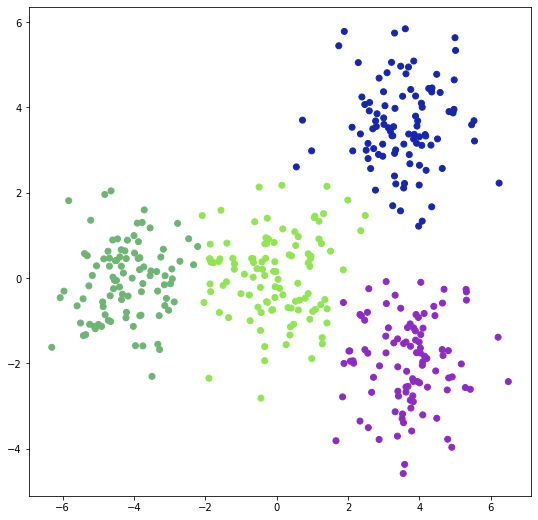

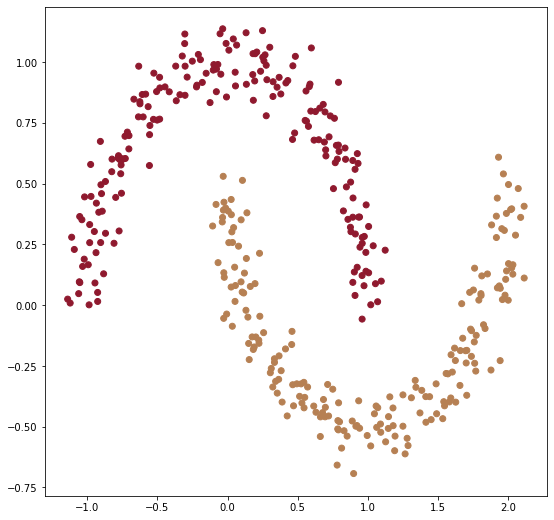

In [346]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [515]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    im_cv = cv2.imread(path)
    im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)
    
    return im_rgb / 255

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    im = np.float32(image * 255)
    im_bgr = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, im_bgr)

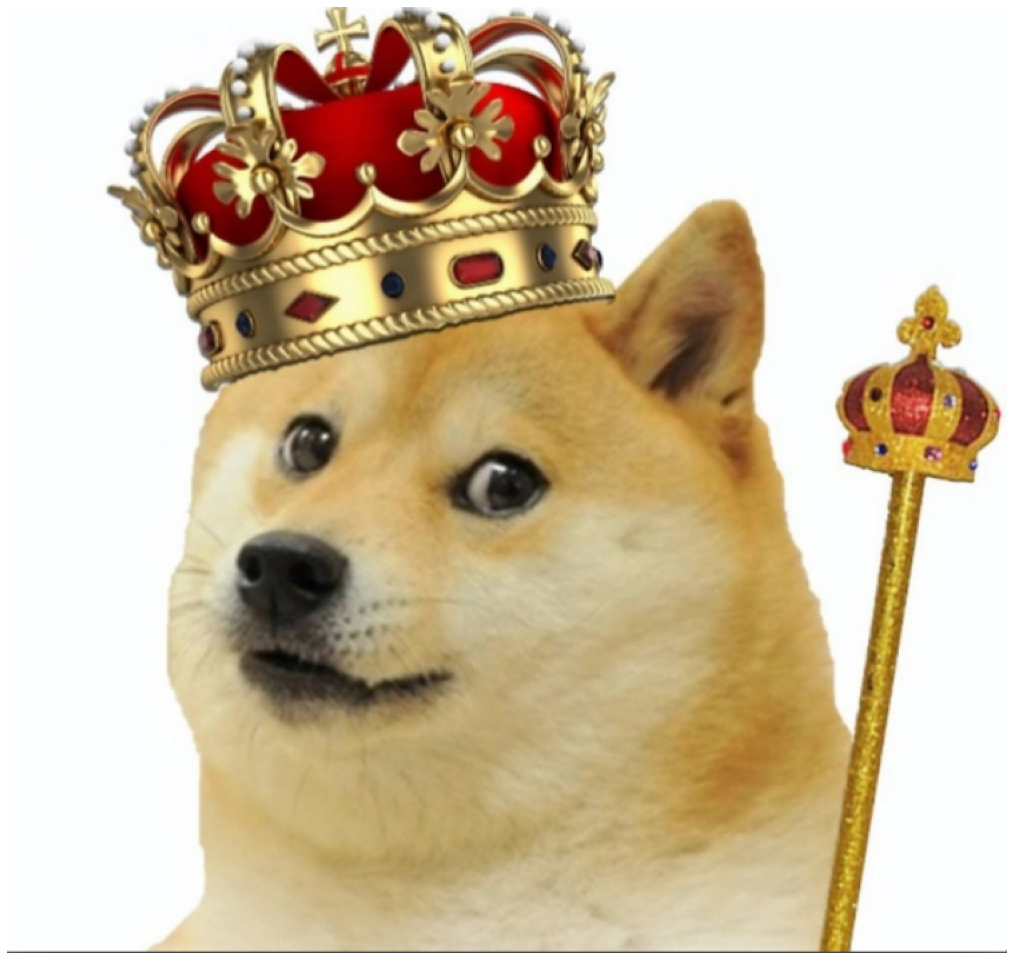

In [517]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [521]:
def clusterize_image(image, n_colors=8, step=4, n_iters=8):
    df = image.reshape(-1, 3)
    start_shape = image.shape
    
    kmeans = KMeans(n_clusters=n_colors, init='sample', max_iter=n_iters)
    kmeans.fit(df[::step])
    labels = kmeans.predict(df)

    cluster_colors = np.array([df[labels == i].mean(axis=0) for i in range(n_colors)]) # color of each cluster
    clusters = labels # Cluster labels for each pixel in flattened image
    recolored = np.array([cluster_colors[i] for i in labels]) # Image with pixel colors assigned to corresponding cluster colors
    
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored.reshape(start_shape)

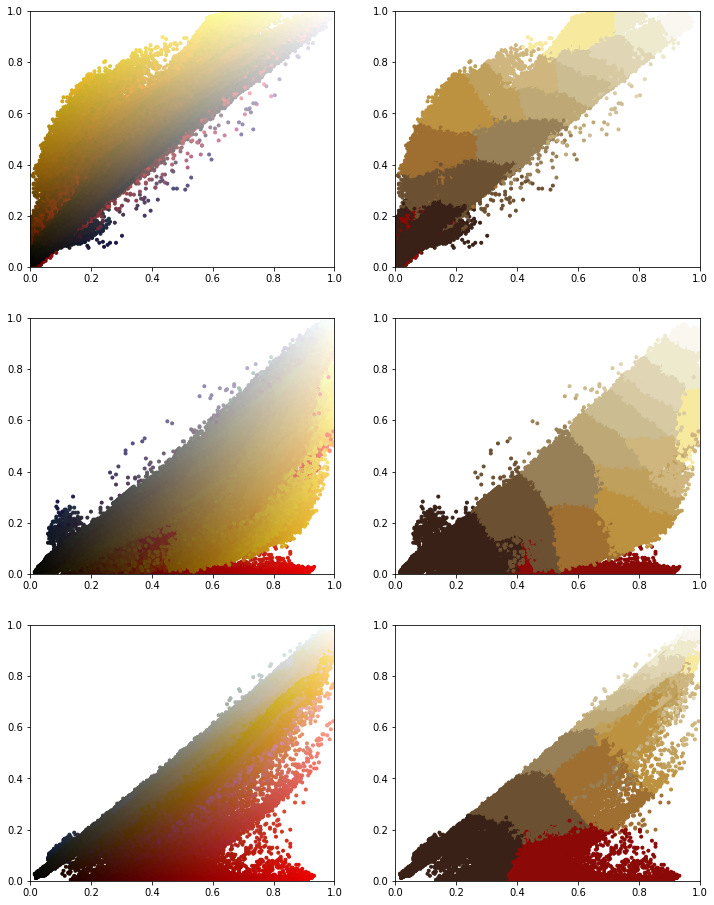

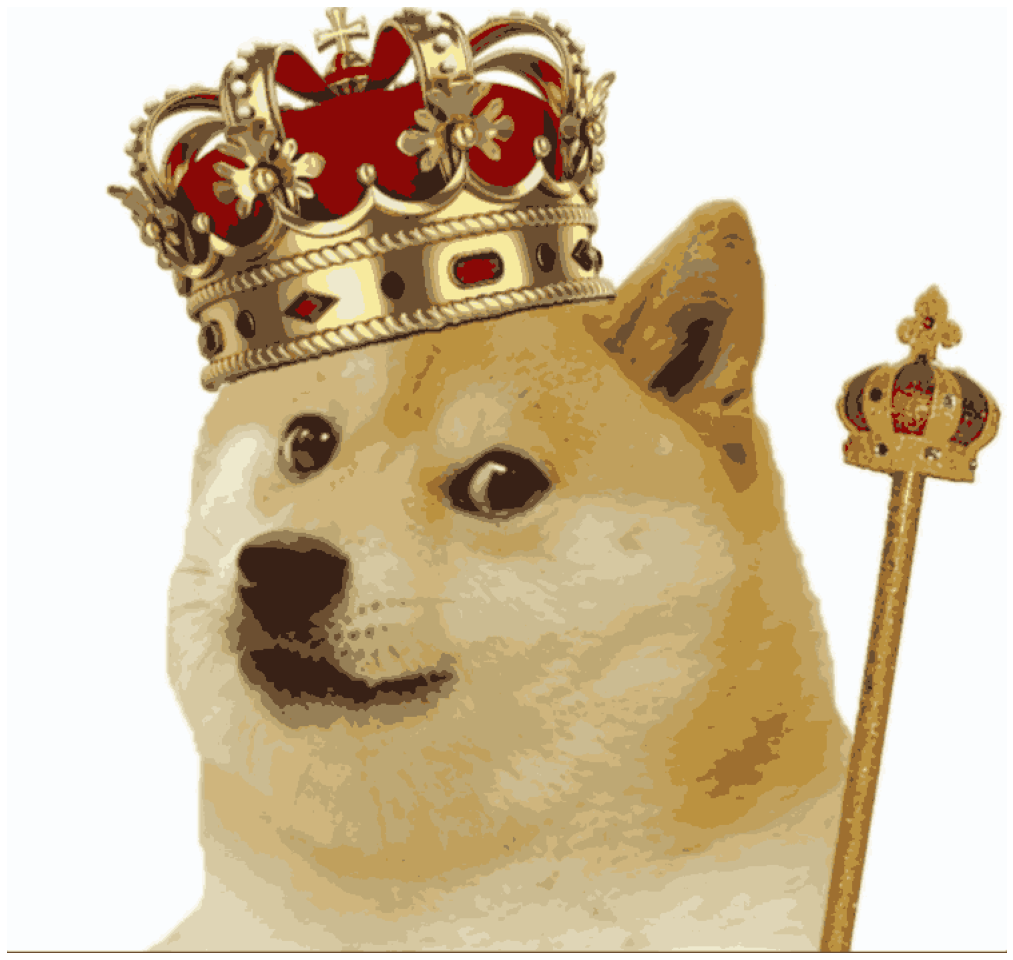

In [522]:
image = read_image("./image.png")
result = clusterize_image(image, n_colors=16, step = 4, n_iters=8)
show_image(result)
save_image(result, "result.png")